##### Copyright 2024 Google LLC.

In [2]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 2 - Classifying embeddings with Keras and the Gemini API

## Overview

Welcome back to the Kaggle 5-day Generative AI course. In this notebook, you'll learn to use the embeddings produced by the Gemini API to **train a model** that can **classify newsgroup posts** into the categories (the newsgroup itself) from the post contents.

This technique uses the Gemini API's **embeddings as input**, avoiding the need to train on text input directly, and as a result it is able to **perform quite well** using relatively few examples compared to training a text model from scratch.

## For help

**Common issues are covered in the [FAQ and troubleshooting guide](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs).**


In [3]:
%pip install -U -q "google-generativeai>=0.8.3"

Note: you may need to restart the kernel to use updated packages.


Note that you do not have to restart the kernel.

In [4]:
import google.generativeai as genai

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [5]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
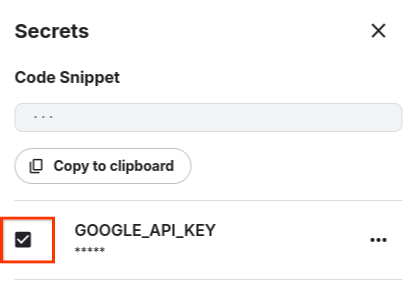

## Dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html) contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. For this tutorial, you will use sampled subsets of the training and test sets, and perform some processing using Pandas.

The **20 Newsgroups Text Dataset** is a well-known dataset for **text classification and natural language processing** tasks. It contains approximately **18,000 posts from 20 different newsgroups** (online discussion forums). The dataset is divided into **training and test sets**, split based on the **date of posting**.

**Features:**

**20 Topics:** The dataset is categorized into 20 distinct topics, which include subjects like sports, politics, technology, science, and religion.

**Structure:** Each post in the dataset represents a document labeled with one of the 20 topics.

**Purpose:** It is widely used to experiment with text classification, clustering, topic modeling, and information retrieval.

In [6]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

**newsgroups_train:** This is a variable (typically a Python object) containing the training subset of the dataset. It typically includes features like:

**target_names:** The actual documents (posts in this case).

**target_names:** The category (topic) label for each document.

**target_names:** A list of the 20 categories (e.g., comp.graphics, sci.med, etc.).

Here is an example of what a record from the training set looks like.

In [7]:
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







Start by **preprocessing the data** for this tutorial in a **Pandas dataframe**. To remove any sensitive information like names and email addresses, you will take only the subject and body of each message. This is an optional step that transforms the input data into more generic text, rather than email posts, so that it will work in other contexts.

In [8]:
import email
import re

import pandas as pd

#preprocess_newsgroup_row(data)
#Role: This function processes a single row of the dataset (a single newsgroup post), 
#extracting relevant information and cleaning it for further analysis.

def preprocess_newsgroup_row(data):
    
    # Extract only the subject and body
    msg = email.message_from_string(data)
    text = f"{msg['Subject']}\n\n{msg.get_payload()}"
    
    # Strip any remaining email addresses
    text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
    
    # Truncate each entry to 5,000 characters
    text = text[:5000]

    return text #It returns the processed text (subject + body, with email addresses removed 
                #and truncated to 5,000 characters).


def preprocess_newsgroup_data(newsgroup_dataset):
    
    # Put data points into dataframe
    df = pd.DataFrame(
        {"Text": newsgroup_dataset.data, "Label": newsgroup_dataset.target}
    )
    
    # Clean up the text
    df["Text"] = df["Text"].apply(preprocess_newsgroup_row)
    
    # Match label to target name index
    df["Class Name"] = df["Label"].map(lambda l: newsgroup_dataset.target_names[l])

    return df

Suppose newsgroup_dataset.target_names contains: **["comp.graphics", "sci.med", "rec.sport.hockey"]**

Your df["Label"] column contains: **[0, 2, 1, 0, 2]**

This should results in: 
**df["Class Name"] = ["comp.graphics", "rec.sport.hockey", "sci.med", "comp.graphics", "rec.sport.hockey"]**


To solve this, you need to map each value in df["Label"] to the corresponding entry in newsgroup_dataset.target_names using the .map() method


In [9]:
# Apply preprocessing function to training and test datasets

df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\n\n I was wondering if anyo...,7,rec.autos
1,SI Clock Poll - Final Call\n\nA fair number of...,4,comp.sys.mac.hardware
2,"PB questions...\n\nwell folks, my mac plus fin...",4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\n\nRobert J.C. Kyanko () wr...,1,comp.graphics
4,Re: Shuttle Launch Question\n\nFrom article <>...,14,sci.space


Next, you will **sample some of the data** by taking **100 data points** in the training dataset, and **dropping a few of the categories** to run through this tutorial. Choose the **science categories** to compare.

In [10]:
def sample_data(df, num_samples, classes_to_keep):
    
    # Sample rows, selecting num_samples of each Label.
    df = (
        df.groupby("Label")[df.columns]
        .apply(lambda x: x.sample(num_samples))
        .reset_index(drop=True)
    )

    df = df[df["Class Name"].str.contains(classes_to_keep)]

    # We have fewer categories now, so re-calibrate the label encoding.
    df["Class Name"] = df["Class Name"].astype("category")
    df["Encoded Label"] = df["Class Name"].cat.codes

    return df


**Difference Between "Label" and "Encoded Label"**

**- Label :**

This comes directly from the newsgroups dataset.
It is the original numerical label assigned to the categories by the dataset itself. For instance, sci.crypt might have a Label value of 11, sci.electronics might be 12, etc.
These numbers cover all categories in the dataset, even those not included in your current subset (e.g., sports or graphics categories).

**- Encoded Label :**

This is a new, re-indexed label created for only the science categories you are working with.
It remaps the Label values to a smaller range, starting from 0. 

For example:

**.** sci.crypt → Encoded Label = 0

**.** sci.electronics → Encoded Label = 1

**.** sci.med → Encoded Label = 2

This ensures that only the selected science categories are represented in a contiguous, simpler numerical form.



**Why Do This?**

When working with a subset of data:

**Original labels (Label)** can skip numbers or include unrelated classes. For example, Label might jump from 11 (sci.crypt) to 15 (rec.sport.hockey), even if you are only interested in science-related topics.

**Encoded labels** ensure the numerical representation is compact and exclusive to the subset of interest. This is useful for models that expect target labels starting from 0.

In [11]:
TRAIN_NUM_SAMPLES = 100
TEST_NUM_SAMPLES = 25
CLASSES_TO_KEEP = "sci"  # Class name should contain 'sci' to keep science categories

df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

In [12]:
df_train.value_counts("Class Name")

Class Name
sci.crypt          100
sci.electronics    100
sci.med            100
sci.space          100
Name: count, dtype: int64

In [13]:
df_test.value_counts("Class Name")

Class Name
sci.crypt          25
sci.electronics    25
sci.med            25
sci.space          25
Name: count, dtype: int64

## Create the embeddings

In this section, you will generate embeddings for each piece of text using the Gemini API embeddings endpoint. To learn more about embeddings, visit the [embeddings guide](https://ai.google.dev/docs/embeddings_guide).

**NOTE**: Embeddings are computed one at a time, so large sample sizes can take a long time!

### Task types

The `text-embedding-004` model supports a task type parameter that generates embeddings tailored for the specific task.

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.
FACT_VERIFICATION | Specifies that the given text will be used for fact verification.

For this example you will be performing **classification**.

In [14]:
from google.api_core import retry
from tqdm.rich import tqdm


tqdm.pandas()

@retry.Retry(timeout=300.0)

def embed_fn(text: str) -> list[float]:
    # You will be performing classification, so set task_type accordingly.
    response = genai.embed_content(
        model="models/text-embedding-004", 
        content=text, 
        task_type="classification"
    )

    return response["embedding"]


def create_embeddings(df):
    df["Embeddings"] = df["Text"].progress_apply(embed_fn)
    return df

This code is optimised for clarity, and is not particularly fast. It is left as an exercise for the reader to implement [batch](https://ai.google.dev/api/embeddings#method:-models.batchembedcontents) or parallel/asynchronous embedding generation. Running this step will take some time.

In [15]:
df_train = create_embeddings(df_train)
df_test = create_embeddings(df_test)

Output()

/opt/conda/lib/python3.10/site-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


Output()

/opt/conda/lib/python3.10/site-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


In [25]:
df_train

,Text,Label,Class Name,Encoded Label,Embeddings
1100,Re: Clipper will corrupt cops (was WH proposal...,11,sci.crypt,0,"[0.0033489978, 0.028391454, -0.061467007, 0.01..."
1101,Re: The [secret] source of that announcement\n...,11,sci.crypt,0,"[0.0074691195, 0.0142706735, -0.04125754, 0.05..."
1102,Cryptography FAQ 06/10 - Public Key Cryptograp...,11,sci.crypt,0,"[0.008693289, 0.031696804, -0.05216084, -0.003..."
1103,"Re: Pgp, PEM, and RFC's (Was: Cryptography Pat...",11,sci.crypt,0,"[-0.01617158, 0.02092663, -0.036431555, -0.001..."
1104,Cryptography FAQ 07/10 - Digital Signatures\n\...,11,sci.crypt,0,"[0.008558255, 0.036278404, -0.06040049, -0.005..."
...,...,...,...,...,...
1495,Space FAQ 01/15 - Introduction\n\nArchive-name...,14,sci.space,3,"[0.026150076, 0.009918035, -0.04995389, 0.0019..."
1496,RE: Looking for a little research help\n\nFoun...,14,sci.space,3,"[-0.02370545, 0.01958105, -0.018769145, 0.0529..."
1497,"Orbit data - help needed\n\nI have the ""oscula...",14,sci.space,3,"[0.035229146, 0.0059486832, -0.049370125, 0.03..."
1498,Space Advertising (1 of 2)\n\nBrian Yamauchi a...,14,sci.space,3,"[0.021743981, 0.008397602, -0.055070955, 0.019..."


In [36]:
df_train["Class Name"]

1100    sci.crypt
1101    sci.crypt
1102    sci.crypt
1103    sci.crypt
1104    sci.crypt
          ...    
1495    sci.space
1496    sci.space
1497    sci.space
1498    sci.space
1499    sci.space
Name: Class Name, Length: 400, dtype: category
Categories (4, object): ['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space']

In [39]:
df_train["Class Name"].cat.categories[2]

'sci.med'

## Build a classification model

Here you will define a simple model that accepts the raw embedding data as input, has one hidden layer, and an output layer specifying the class probabilities. The prediction will correspond to the probability of a piece of text being a particular class of news.

When you run the model, Keras will take care of details like shuffling the data points, calculating metrics and other ML boilerplate.

In [17]:
import keras
from keras import layers


def build_classification_model(input_size: int, num_classes: int) -> keras.Model:
    return keras.Sequential(
        [
            layers.Input([input_size], name="embedding_inputs"),
            layers.Dense(input_size, activation="relu", name="hidden"),
            layers.Dense(num_classes, activation="softmax", name="output_probs"),
        ]
    )

In [18]:
# Derive the embedding size from observing the data. The embedding size can also be specified
# with the `output_dimensionality` parameter to `embed_content` if you need to reduce it.
embedding_size = len(df_train["Embeddings"].iloc[0])

classifier = build_classification_model(
    embedding_size, len(df_train["Class Name"].unique())
)
classifier.summary()

classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_probs (Dense)            │ (None, 4)              │         3,076 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 593,668 (2.26 MB)

 Trainable params: 593,668 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

Finally, you can train your model. This code uses early stopping to exit the training loop once the loss value stabilises, so the number of epoch loops executed may differ from the specified value.

In [19]:
import numpy as np


NUM_EPOCHS = 20
BATCH_SIZE = 32

# Split the x and y components of the train and validation subsets.
y_train = df_train["Encoded Label"]
x_train = np.stack(df_train["Embeddings"])

y_val = df_test["Encoded Label"]
x_val = np.stack(df_test["Embeddings"])

# Specify that it's OK to stop early if accuracy stabilises.
early_stop = keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

# Train the model for the desired number of epochs.
history = classifier.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3030 - loss: 1.3628 - val_accuracy: 0.6800 - val_loss: 1.2682
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6966 - loss: 1.2013 - val_accuracy: 0.7600 - val_loss: 1.1060
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8411 - loss: 1.0107 - val_accuracy: 0.8800 - val_loss: 0.9287
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8947 - loss: 0.8294 - val_accuracy: 0.8800 - val_loss: 0.7792
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9266 - loss: 0.6450 - val_accuracy: 0.9100 - val_loss: 0.6518
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9664 - loss: 0.4855 - val_accuracy: 0.9500 - val_loss: 0.5064
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9602 - loss: 0.3946 - val_accuracy: 0.9300 - val_loss: 0.4205
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9743 - loss: 0.2884 - val_accuracy: 0.9700 - val_loss

## Evaluate model performance

Use Keras <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate"><code>Model.evaluate</code></a> to calculate the loss and accuracy on the test dataset.

In [20]:
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9385 - loss: 0.1878 


{'accuracy': 0.9399999976158142, 'loss': 0.18381650745868683}

To learn more about training models with Keras, including how to visualise the model training metrics, read [Training & evaluation with built-in methods](https://www.tensorflow.org/guide/keras/training_with_built_in_methods).

## Try a custom prediction

Now that you have a trained model with good evaluation metrics, you can try to make a prediction with new, hand-written data. Use the provided example or try your own data to see how the model performs.

In [40]:
# This example avoids any space-specific terminology to see if the model avoids
# biases towards specific jargon.

new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""
embedded = embed_fn(new_text)
embedded

[0.019432709,
 -0.0134165445,
 -0.038569827,
 0.027099848,
 0.030647298,
 0.0552539,
 0.089664415,
 0.040378496,
 -0.010588484,
 0.009992522,
 0.031105185,
 0.041578043,
 0.029177554,
 -0.0058882097,
 0.049694806,
 -0.04701471,
 0.08547439,
 0.06041958,
 -0.041273843,
 -0.02578345,
 -0.0055946195,
 0.018798409,
 -0.0111317085,
 0.011139821,
 -0.0051660193,
 0.030108875,
 0.04181174,
 -0.012075451,
 0.0108866645,
 -0.015594199,
 0.017580828,
 0.04662013,
 0.04908052,
 -0.016169475,
 0.051437464,
 0.007593721,
 -0.0024948507,
 -0.010638129,
 0.027199747,
 -0.07219817,
 -0.05390348,
 0.022033947,
 -0.0032580693,
 0.03200955,
 -0.04087985,
 -0.049519826,
 -0.05676126,
 -0.02587544,
 -0.06374949,
 0.010307776,
 0.0033229957,
 0.057755854,
 -0.047802165,
 0.0480191,
 0.0029020114,
 -0.020711409,
 -0.0018620442,
 -0.038993567,
 0.037544888,
 -0.093531534,
 -0.005849261,
 -0.024610138,
 0.03038399,
 -0.010527783,
 -0.013461092,
 -0.053257346,
 -0.031193351,
 0.03940577,
 -0.038611542,
 -0.0012

In [41]:
# Remember that the model takes embeddings as input, and the input must be batched,
# so here they are passed as a list to provide a batch of 1.
inp = np.array([embedded])

[result] = classifier.predict(inp)

[result]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[array([3.6263312e-04, 2.7456896e-03, 3.3117080e-04, 9.9656051e-01],
       dtype=float32)]

In [28]:
for idx, category in enumerate(df_test["Class Name"].cat.categories):
    print(f"{category}: {result[idx] * 100:0.2f}%")

sci.crypt: 0.04%
sci.electronics: 0.27%
sci.med: 0.03%
sci.space: 99.66%


These probabilities allow you to interpret the confidence level for each class instead of just assigning a single predicted class (which could be determined by taking the class with the highest probability).

This code is useful for understanding how confident the model is about each class for a given input.

We can directly obtain **the predicted class** by selecting the index of **the highest probability** from the result array and mapping it back to the corresponding class. 

Here's how we can do it :

In [30]:
# Get the index of the maximum probability
predicted_index = np.argmax(result)

# Map the index to the class name
predicted_class = df_test["Class Name"].cat.categories[predicted_index]

print(f"The input has been classified as belonging to the following category: {predicted_class}")


The input has been classified as belonging to the following category: sci.space
